In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)
        
import os
# Uncomment for CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import utils.hdf5_experiment as EXP
import sacred
import matplotlib.pyplot as plt

tf.__version__

'2.1.0'

<KeysViewHDF5 ['actions', 'checkpoints', 'observations', 'rewards', 'track', 'track_len']>


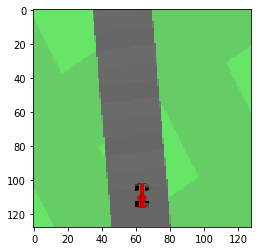

In [2]:
print(EXP.HD.keys())

im = EXP.OBSERVATIONS[0, 900]
plt.imshow(im / 255)

In [11]:
@EXP.EX.config
def config():
    SEQ_LEN = 128
    W, H = 128, 128
    internal_size = 32
    batch_size = 2
    steps_per_epoch = 128
    lr = 0.001
    weight_decay = 0.0001
    should_preload_model = True

WARNING - DRNN Car Racing 3 - No observers have been added to this run
INFO - DRNN Car Racing 3 - Running command 'main'
INFO - DRNN Car Racing 3 - Started


(None, None, 32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
action (InputLayer)             [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
initializer (Sequential)        (None, 32)           2320        condition[0][0]                  
__________________________________________________________________________________________________
memory (Model)                  (None, None, 32)     16608       action[0][0]                     
                                                                 initialize

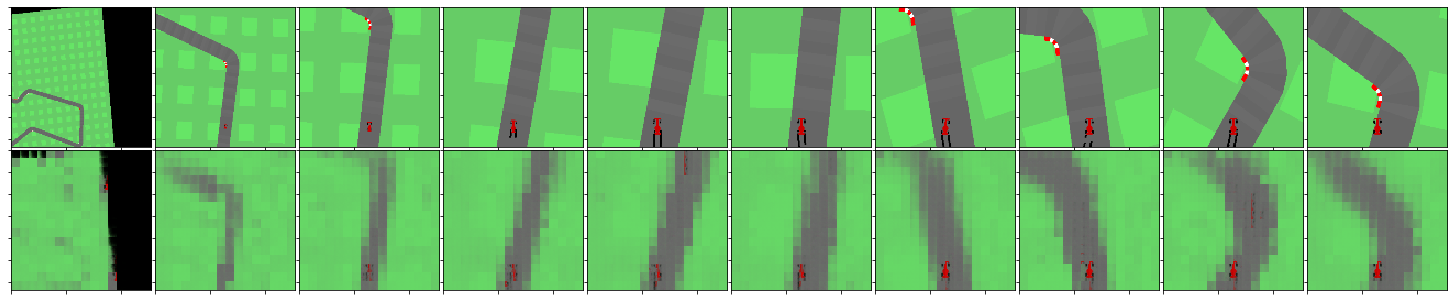

Epoch 1/100
  1/128 [..............................] - ETA: 51s

ERROR - DRNN Car Racing 3 - Failed after 0:00:05!


KeyError: 'loss'

In [12]:
# EXP.EX.observers.append(sacred.observers.MongoObserver())
EXP.EX.run(config_updates={'should_preload_model': True})

In [17]:
model = EXP.MODEL
model.net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
action (InputLayer)             [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
initializer (Sequential)        (None, 32)           2320        condition[0][0]                  
__________________________________________________________________________________________________
memory (Model)                  (None, None, 32)     16608       action[0][0]                     
                                                                 initializer[1][0]          

In [18]:
model.net.input_shape

[(None, 12, 2), (None, None, 3)]

In [19]:
import numpy as np

In [24]:
example_id = 666
seq_len = 128

actions = EXP.ACTIONS[example_id, :seq_len][np.newaxis, ...]
checkpoint = EXP.CHECKPOINTS[example_id, :seq_len][np.newaxis, ...]
observations = EXP.OBSERVATIONS[example_id, :seq_len]

actions.shape, checkpoint.shape, observations.shape

((1, 128, 3), (1, 12, 2), (128, 128, 128, 3))

In [25]:
pred_obs, pred_reward = model.net([checkpoint, actions])
pred_obs, pred_reward = pred_obs[0], pred_reward[0]
pred_obs.shape, pred_reward.shape

(TensorShape([128, 128, 128, 3]), TensorShape([128, 1]))

In [26]:
pred_int = (pred_obs.numpy() * 255).astype(np.uint8)
obs_int = observations.astype(np.uint8)
split_frame = np.concatenate([obs_int, pred_int], axis=2)
split_frame.shape, np.max(split_frame), np.min(split_frame)

((128, 128, 256, 3), 255, 0)

In [27]:
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc
import cv2

fourcc = VideoWriter_fourcc(*'MP42')
video = VideoWriter('./car.avi', fourcc, 30, (256, 128))

for frame in split_frame:
    f = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video.write(f)
video.release()